In [1]:
from __future__ import unicode_literals, division

import IPython
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict

from pylab import *
from StringIO import StringIO
from scipy.stats import rankdata
from IPython.display import HTML
from IPython.display import display as prnt

# Notebook Options
%matplotlib inline
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Matplotlib Styles
c = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }
wide_c = dict(c, **{'figure.figsize':[20,8]})
thin_c = dict(c, **{'figure.figsize':[16,8]})

# Source Data
id = '1GnTfMdu9LATsemrfHrnWepsVo-H6oma8AZPXgC7RU1k'
url = 'https://docs.google.com/spreadsheets/d/' + id + '/export?format=csv&id'
r = requests.get(url)
df = pd.read_csv(StringIO(r.content))
df.Timestamp = pd.to_datetime(df.Timestamp, dayfirst=True)

# Roster
roster = pd.read_csv('roster.csv').set_index('Multiplier')

# Episodes
episode_list = df['Episode'].unique()

# Awards
awards = ['Wit','Jockey','Bloodshed','Style','Support']
award_votes = [a[:2]+str(n) for a in awards for n in range(1,4)]
awards_points = [32,16,8]
multiplier = [0.125,0.25,0.5,1,2,4,8]

# Prestige
assassin_prestige_points = 1/16

# Players
id = '1DIVq4s9U_nfY3cHcknGjeV3iGpfW_zxUx-bjFNm4Ebo'
url = 'https://docs.google.com/spreadsheets/d/' + id + '/export?format=csv&id'
r = requests.get(url)
bids = pd.read_csv(StringIO(r.content), parse_dates=[u'Timestamp'])

# Merge in Names
voting_record = df.merge(bids[['Name','Email Address']])

# Data Cleaning
voting_record.columns = ['Timestamp'] + award_votes + ['Email','Episode','Name']
voting_record = voting_record[['Episode','Name'] + award_votes + ['Email','Timestamp']]

# Publication
BASE_URL = 'https://nbviewer.ipython.org/gist/tijptjik/9d99b137b2c30b352d1a/'

# Utility Functions
def table(df,replace_match="",replace_str="",index=True):
    return IPython.display.display(HTML(df.to_html(index=index).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace(replace_match,replace_str)))

rank = lambda x: rankdata(1/x, method='min')

def sorted_max(s, num):
    tmp = s.order(ascending=False)[:num]
    tmp.index = range(num)
    return tmp

# HTML Functions
h1 = lambda x : prnt(HTML('''<h1 style="text-align:center">'''+ x +'''</h1>'''))
h2 = lambda x: prnt(HTML('''<h2 style="text-align:center">'''+ x +'''</h2>'''))
h2_success = lambda x: prnt(HTML('''<h2 style="text-align:center" class="alert alert-success">'''+ x +'''</h2>'''))

h3_danger = lambda x: prnt(HTML('''<h3 style="text-align:center" class="alert alert-danger">'''+ x +'''</h3>'''))
h3_info = lambda x: prnt(HTML('''<h3 style="text-align:center" class="alert alert-info">'''+ x +'''</h3>'''))
h3_warning = lambda x: (HTML('''<h3 style="text-align:center" class="alert alert-warning">'''+ x +'''</h3>'''))

h3 = lambda x : prnt(HTML('''<h3 style="text-align:center">'''+ x +'''</h3>'''))
p  = lambda x : prnt(HTML('''<p class="text_cell_render">'''+ x +'''</p>'''))

In [2]:
# DATAFRAMES
import os

fns = os.listdir('.')

get_csvs = lambda x: [fn for fn in fns if fn.startswith(x + '_') & fn.endswith('.csv')]
csv_concat = lambda x: pd.concat([pd.read_csv(fn) for fn in get_csvs(x)], axis=0, ignore_index=True)

# Email <> Player Mappings

email_name_map = pd.read_csv('bids.csv', encoding='utf8', usecols=[1,2])
email_name_map = email_name_map[['Email Address','Name']]
email_name_map.columns = ['Email','Player']
email_name_map

# Votes | IDX : [Episode, Player, Award, Points, Character]
votes = csv_concat('votes')

char_ranks = {}

for char_rank in range(len(roster)):
    for char in roster.iloc[char_rank,:]:
        char_ranks[char] = char_rank
        
votes['Rank'] = 0
for idx, row in votes.iterrows():
    if type(row['Character']) == str:
        votes.ix[idx,'Rank'] = char_ranks[row['Character']]

votes = votes[-votes.Character.isnull()]
# table(votes)

# Vote Timestamp | IDX : [Player, Episode, Timestamp]
vote_timestamps = df.set_index(['Email Address','Episode']).sort()['Timestamp']
vote_timestamps = vote_timestamps.reset_index().merge(email_name_map, left_on='Email Address', right_on='Email')
vote_timestamps = vote_timestamps[['Player','Episode','Timestamp']] 

# Character Score | Character : [Points, Rank]
scores_character = csv_concat('scores_character')
# table(scores_character)

# Character Score | Character : [Points, Rank]
scores_player = csv_concat('scores_player').set_index(['Episode','Multiplier'])
# table(scores_player)

# Performance | Character : [Rating, Rank, Index]
performance = csv_concat('performance')
# table(performance)

# Prestige | Character : [Score]
prestige = pd.read_csv('prestige.csv').set_index('Character').Score
# table(prestige)

# Roster Prestige | Character : [Score, Rank]
roster_prestige = pd.read_csv('roster_prestige.csv')
roster_prestige.columns = ['Character','Score','Rank']
roster_prestige = roster_prestige.set_index('Character')
# table(roster_prestige)

# --- COMPOSED TABLES --- #

# Score Table - Total Scores in Main Game

current_score_table = scores_player.groupby(level=0).sum().T
index = current_score_table.index
columns = range(len(current_score_table.columns),11)

df_ = pd.DataFrame(index=index, columns=columns)
df_ = df_.fillna(0) # with 0s rather than NaNs

score_table =  pd.concat([current_score_table, df_], axis=1)
score_table.columns = range(1,11) + ['Total']
score_table.Total = score_table.T.sum()
score_table['Rank'] = rank(score_table.Total)
score_table = score_table.sort('Rank').astype(int)


# Character <> Player Mappings

player_char_map = defaultdict(list)
char_player_map = defaultdict(list)

for player, chars in roster.iteritems():
    for char in chars:
        player_char_map[player].append(char)
        char_player_map[char].append(player)
        
# Character <> Multiplier Mappings

char_mult_map = {}

for mult, row in roster.iterrows():
    for char in row:
        char_mult_map[char] = mult
        
# SHORTHANDS SETS

char_with_votes = votes.Character.unique().tolist()
char_without_votes = pd.Index.diff(pd.Index(list(set(roster.values.ravel()))), votes.Character.unique().tolist())
char_who_died = ['Barristan Selmy','Mance Rayder','Lord of Bones','Hizdahr zo Loraq','Shireen Baratheon','Janos Slynt',
                'Myranda','Jon Snow','Stannis Baratheon','Meryn Trant','Selyse Baratheon','']

## Player Voted Ratio

no_compulsory_votes = 10 * 5 * 2
disqualified_cut_off = 0.8 * no_compulsory_votes

player_voted_ratio = votes.groupby('Player').Episode.count() / 10 / 15
player_voted_ratio.sort(ascending=False)
player_voted_ratio = pd.DataFrame(player_voted_ratio * 100)
player_voted_ratio['Rank'] = rank(player_voted_ratio.Episode)
player_voted_ratio['Disqualified'] = player_voted_ratio.Episode < disqualified_cut_off / 10 / 15 * 100
player_voted_ratio.index.name = None
player_voted_ratio.columns = ['% Voted', 'Rank', 'Disqualified']

## Paired Votes

invisible_links = {}
# Index = Voter, Col = Votee
paired_votes = pd.DataFrame(columns=votes.Player.unique(), index=votes.Player.unique()).fillna(0)

for player in votes.Player.unique().tolist():
    invisible_links[player] = defaultdict(int)

for idx, row in votes.iterrows():
    for recipient in char_player_map[row.Character]:
        invisible_links[row.Player][recipient] += 1 * (1 / player_voted_ratio.ix[row.Player, '% Voted'])

for player, votees in invisible_links.iteritems():
    for votee, count in votees.iteritems():
        paired_votes.ix[player,votee] = count



In [3]:
# Episodes Aired
h1('ASCENSION | AWARD CEREMONY')
h2('Game of Thones : Season 5')

In [4]:
HTML('''<script>

code_show=true;

function code_toggle() {
    if (code_show){ 
        $('div.input').hide();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').hide();
    } else {
        $('div.input').show();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').show();
    }
    code_show = !code_show
}
</script>
 
<a class='btn btn-warning btn-lg' style="margin:0 auto; display:block; max-width:320px" href="javascript:code_toggle()">TOGGLE CODE</a>''')

In [5]:
h2_success('Awards')

award_desc = lambda x,y,z: {'title': x, 'description': y, 'winner': z}
awarded_awards = []

h3_info('Character Awards')

char_awards =  ['Category Award - Wit',
                'Player Category Award - Wit',
                'Category Award - Jockey',
                'Player Category Award - Jockey',
                'Category Award - Bloodshed',
                'Player Category Award - Bloodshed',
                'Category Award - Style',
                'Player Category Award - Style',
                'Category Award - Support',
                'Player Category Award - Support',
                'Most Valuable Character',
                'All stars roster - highest scoring character for each rank',
               ]

elements = []
for idx, award in enumerate(char_awards):
    elements.append('''<a style="display:block; margin:0 auto;"><span class="badge badge-info">'''+ award +'''</span></a>''')
    
prnt(HTML("".join(elements)))

In [6]:
h2_success('Awards')

h3_info('Player Awards')

player_awards = [
'Bleeding Heart - who disproportionately votes for non-prestigious characters',
'One-Trick Pony - who disproportionately relied on a single character for points',
'War of Attrition - whose votes rendered the least points',
'Squeeze the Vote - Most Efficient Use of Votes',
'Most Controversial Roster - Roster Most Dividing Opinions',
'Odd-ball - Voting Behaviour Most at Odds with Other Players']

elements = []
for idx, award in enumerate(player_awards):
    elements.append('''<a style="display:block; margin:0 auto;"><span class="badge badge-info">'''+ award +'''</span></a>''')
    
prnt(HTML("".join(elements)))

In [7]:
h2_success('Awards')
h3_info('Game Awards')

game_awards = [
    'Sleeper Hit - Roster Most Outperforming Expectations',
    'Quickfinger - Fasted Airtime-to-Vote',
    'Shadow Game - points awarded standardised by rank',
    'Lifting the Veil - points awarded without multipliers',
    'Ascension Award - most points. no bullshit.'
]

elements = []
for idx, award in enumerate(game_awards):
    elements.append('''<a style="display:block; margin:0 auto;"><span class="badge badge-info">'''+ award +'''</span></a>''')
    
prnt(HTML("".join(elements)))

In [8]:
h2_success('To Our Dearly Departed')

In [9]:
# table(roster,index=False)
r = roster.copy()
r.index.name = None
IPython.display.display(HTML(r.to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

Daisy,Dan,Hayley,Ivarius Ironsight,Jannerah Silverscale,Josh Du,Kent,Kirsty,Mart,Max Ng,Rob o Bones,Sherin the Sedulous
Petyr Baelish,Margaery Tyrell,Brienne of Tarth,Grey Worm,Petyr Baelish,Tyrion Lannister,Varys,Davos Seaworth,Tyrion Lannister,Petyr Baelish,Petyr Baelish,Varys
Maggy the Frog,Pit Announcer,Mance Rayder,Lord of Bones,Arya Stark,Theon Greyjoy,Nymeria Sand,Myrcella Baratheon,Daario Naharis,Daenerys Targaryen,Ramsay Bolton,Jaqen Hghar
Pycelle,Melisandre,Sansa Stark,Gregor Clegane,Sansa Stark,Walda Bolton,Kevan Lannister,Lancel Lannister,The High Sparrow,Jon Snow,Areo Hotah,Olenna Tyrell
Ternesio Terys,Eddison Tollett,Ser Bronn,Yohn Royce,Septa Unella,Jaime Lannister,Mace Tyrell,Malko,Lhara,Cersei Lannister,Bowen Marsh,Tycho Nestoris
Meryn Trant,Jorah Mormont,Robin Arryn,Samwell Tarly,Jorah Mormont,Tyene Sand,Denys Mallister,Shireen Baratheon,Ellaria Sand,Stannis Baratheon,White Walkers Master,Ellaria Sand
Barristan Selmy,Trystane Martell,Podrick Payne,Myranda,Loboda,Alliser Thorne,Tormund Giantsbane,Keyr,Loras Tyrell,Janos Slynt,Trystane Martell,Doran Martell
Olly,Missandei,Gilly,Maggy the Frog,Tommen Baratheon,Yezzan,Hizdahr zo Loraq,Pit Announcer,Qyburn,Roose Bolton,Selyse Baratheon,Obara Sand


In [10]:
for k,v in r.iterkv():
    for character in v:
        if character in char_who_died:
            v[v == character] = 'dead'
IPython.display.display(HTML(r.to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-').replace('dead','<b style="color:red">DEAD</b>')))

Daisy,Dan,Hayley,Ivarius Ironsight,Jannerah Silverscale,Josh Du,Kent,Kirsty,Mart,Max Ng,Rob o Bones,Sherin the Sedulous
Petyr Baelish,Margaery Tyrell,Brienne of Tarth,Grey Worm,Petyr Baelish,Tyrion Lannister,Varys,Davos Seaworth,Tyrion Lannister,Petyr Baelish,Petyr Baelish,Varys
Maggy the Frog,Pit Announcer,DEAD,DEAD,Arya Stark,Theon Greyjoy,Nymeria Sand,Myrcella Baratheon,Daario Naharis,Daenerys Targaryen,Ramsay Bolton,Jaqen Hghar
Pycelle,Melisandre,Sansa Stark,Gregor Clegane,Sansa Stark,Walda Bolton,Kevan Lannister,Lancel Lannister,The High Sparrow,DEAD,Areo Hotah,Olenna Tyrell
Ternesio Terys,Eddison Tollett,Ser Bronn,Yohn Royce,Septa Unella,Jaime Lannister,Mace Tyrell,Malko,Lhara,Cersei Lannister,Bowen Marsh,Tycho Nestoris
DEAD,Jorah Mormont,Robin Arryn,Samwell Tarly,Jorah Mormont,Tyene Sand,Denys Mallister,DEAD,Ellaria Sand,DEAD,White Walkers Master,Ellaria Sand
DEAD,Trystane Martell,Podrick Payne,DEAD,Loboda,Alliser Thorne,Tormund Giantsbane,Keyr,Loras Tyrell,DEAD,Trystane Martell,Doran Martell
Olly,Missandei,Gilly,Maggy the Frog,Tommen Baratheon,Yezzan,DEAD,Pit Announcer,Qyburn,Roose Bolton,DEAD,Obara Sand


In [11]:
player_with_dead_characters = []
player_without_dead_characters = []
for player, rst in r.iteritems():
    if 'dead' in rst.tolist():
        player_with_dead_characters.append(player)
    else:
        player_without_dead_characters.append(player)
        
h2_success('Victory in Death?')
p('How <i>do</i> you put a number on life? Is their reward in Death?')

In [12]:
p('Players <i>with</i> Dead Characters on their roster')
score_with = score_table[score_table.index.isin(player_with_dead_characters)]['Total'].sum()
print 'TOTAL SCORE : {:.0f}'.format(score_with)

TOTAL SCORE : 22584


In [13]:
p('Players <i>without</i> Dead Characters on their roster')
score_without = score_table[score_table.index.isin(player_without_dead_characters)]['Total'].sum()
print 'TOTAL SCORE : {:.0f}'.format(score_without)

TOTAL SCORE : 23044


In [14]:

print "VERDICT: It's {:.1f}% better not to die!".format(100 - score_with / score_without  * 100)

VERDICT: It's 2.0% better not to die!


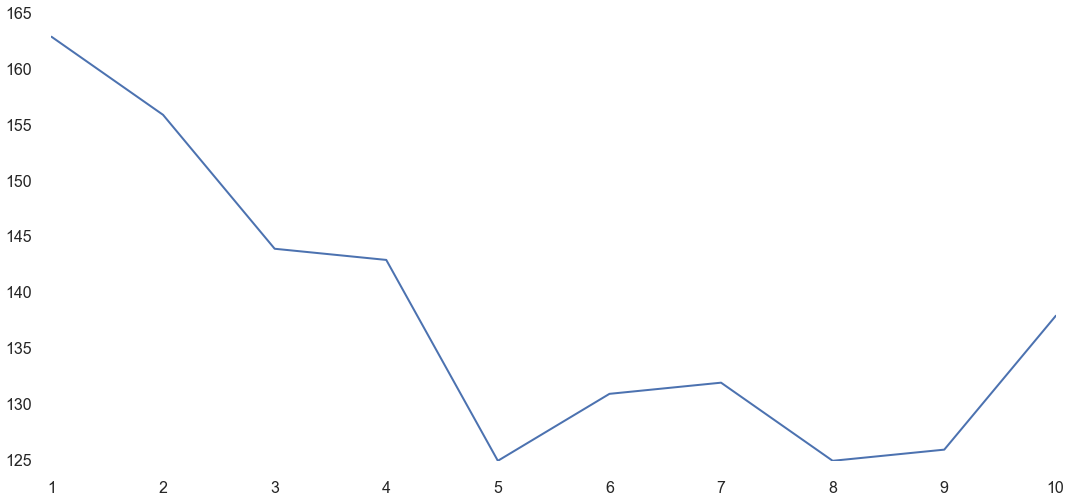

In [15]:
h2_success('Number of Votes Cast per Episode')
with sns.plotting_context("poster", rc=c):
    t = votes.groupby('Episode').Award.count()
    t.index = range(1,len(t.index)+1)
    t.plot()
    plt.ylim = (100,170)

# CATEGORY AWARDS

In [16]:
category_awards = votes.groupby(['Award','Character']).sum()[['Points']].reset_index().sort(columns=['Award','Points'], ascending=False).set_index(['Award','Character'])

def award_header(seq):
    h2_success(awards[seq].upper() + ' Award'.upper())

def get_category_award(seq):
    idx = seq
    awrd = awards[idx]
    h2_success(awrd.upper() + ' Award'.upper())
    winner = category_awards.ix[awrd][:1].index[0]
    h3_danger(category_awards.ix[awrd][:1].index[0].upper())

    category_award = category_awards.ix[awrd]
    category_award['Rank'] = rank(category_award.Points)
    pd.options.display.float_format = '{:.0f}'.format

    table(category_award.reset_index()[:5],index=False)

    desc = "Character who accumalted most points in the " + awards[seq] + "  Category" 
    awarded_awards.append(award_desc(awrd, desc, winner))
    return category_award

def player_category_award(category_award, seq):

    player_cat_award = defaultdict(int)

    for char, row in category_award.iterrows():
        for player in char_player_map[char]:
            player_cat_award[player] += row.Points

    df_player_cat_award = pd.DataFrame(player_cat_award.values(), index=player_cat_award.keys(), columns=['Score'])
    df_player_cat_award = df_player_cat_award.sort('Score', ascending=False)
    df_player_cat_award['Rank'] = rank(df_player_cat_award.Score)

    h2_success('PLAYER ' + awards[seq].upper() + ' Award'.upper())
    winner = df_player_cat_award.index[0]
    h3_danger(winner.upper())
    
    desc = "Player who accumalted most points in the " + awards[seq] + "  Category" 
    awarded_awards.append(award_desc('Player ' + awards[seq], desc, winner))
    pd.options.display.float_format = '{:.0f}'.format

    table(df_player_cat_award)

In [17]:
seq = 0
award_header(seq)

In [18]:
category_award = get_category_award(seq)

Character,Points,Rank
Tyrion Lannister,1024,1
Varys,488,2
Ser Bronn,456,3
Jaqen Hghar,296,4
Olenna Tyrell,296,4


In [19]:
player_category_award(category_award, seq)

,Score,Rank
Mart,1488,1
Sherin the Sedulous,1368,2
Josh Du,1184,3
Kent,784,4
Max Ng,672,5
Hayley,672,5
Dan,520,7
Jannerah Silverscale,368,8
Ivarius Ironsight,272,9
Daisy,272,9


In [20]:
seq = 1
award_header(seq)

In [21]:
category_award = get_category_award(seq)

Character,Points,Rank
Cersei Lannister,728,1
Jon Snow,552,2
Petyr Baelish,544,3
Margaery Tyrell,384,4
The High Sparrow,344,5


In [22]:
player_category_award(category_award, seq)

,Score,Rank
Max Ng,2360,1
Jannerah Silverscale,984,2
Mart,928,3
Rob o Bones,784,4
Sherin the Sedulous,736,5
Dan,704,6
Daisy,544,7
Josh Du,432,8
Kent,384,9
Ivarius Ironsight,344,10


In [23]:
seq = 2
award_header(seq)

In [24]:
category_award = get_category_award(seq)

Character,Points,Rank
Ramsay Bolton,656,1
Jon Snow,528,2
Arya Stark,440,3
Jorah Mormont,440,3
Daenerys Targaryen,352,5


In [25]:
player_category_award(category_award, seq)

,Score,Rank
Max Ng,1168,1
Jannerah Silverscale,1064,2
Hayley,904,3
Rob o Bones,880,4
Dan,632,5
Ivarius Ironsight,440,6
Mart,296,7
Daisy,296,7
Josh Du,264,9
Kirsty,256,10


In [26]:
seq = 3
award_header(seq)

In [27]:
category_award = get_category_award(seq)

Character,Points,Rank
Daenerys Targaryen,656,1
Margaery Tyrell,456,2
Sansa Stark,352,3
Cersei Lannister,328,4
Tyene Sand,288,5


In [28]:
player_category_award(category_award, seq)

,Score,Rank
Max Ng,1272,1
Jannerah Silverscale,1048,2
Dan,1008,3
Josh Du,632,4
Sherin the Sedulous,584,5
Mart,552,6
Rob o Bones,512,7
Kirsty,496,8
Hayley,456,9
Ivarius Ironsight,256,10


In [29]:
seq = 4
award_header(seq)

In [30]:
category_award = get_category_award(seq)

Character,Points,Rank
Samwell Tarly,552,1
Davos Seaworth,440,2
Theon Greyjoy,432,3
Brienne of Tarth,360,4
Jorah Mormont,360,4


In [31]:
player_category_award(category_award, seq)

,Score,Rank
Hayley,1008,1
Mart,944,2
Josh Du,864,3
Kirsty,712,4
Ivarius Ironsight,656,5
Dan,584,6
Jannerah Silverscale,576,7
Kent,568,8
Sherin the Sedulous,504,9
Max Ng,264,10


In [32]:
overall_award = votes.groupby(['Character']).sum()[['Points']].reset_index().sort(columns=['Points'], ascending=False).set_index(['Character'])
h2_success('Most Valuable Character'.upper())

In [33]:
h2_success('Most Valuable Character'.upper())
h3_danger(overall_award[:1].index[0].upper())
overall_award['Rank'] = rank(overall_award.Points)

winner = overall_award.index[0]
desc = 'Player who accumulated the most points across all award categories'
awarded_awards.append(award_desc('Most Valuable Player', desc, winner))


pd.options.display.float_format = '{:.0f}'.format

table(overall_award.reset_index().set_index('Rank')[:5])

,Character,Points
Rank,,
1,Tyrion Lannister,1752
2,Daenerys Targaryen,1432
3,Jon Snow,1360
4,Cersei Lannister,1184
4,Jorah Mormont,1184


In [34]:
p('What if someone had drafted the strongest characters for each rank...')

In [35]:
p('How many points would they have earned? That\'s the maximum possible score in Ascenion. You can use that as a baseline to compare how well effective your voting strategy was')

In [36]:
allstars = votes.groupby(['Rank','Character']).sum()[['Points']].reset_index().sort(columns=['Rank','Points'], ascending=[True,False]).set_index(['Rank','Character'])

alls = []
for i in range(len(allstars.index.levels[0])):
    alls.append(allstars.ix[i][:1])
allstar_roster = pd.concat(alls)
allstar_roster['Score'] = allstar_roster.Points * multiplier
allstar_roster['Multiplier'] = multiplier

h2_success('ALLSTARS ROSTER SCORE')

h3_danger(str(int(allstar_roster.Score.sum())) + ' Points')

col_order = ['Multiplier','Character','Points','Score']
table(allstar_roster.reset_index()[col_order], index=False)

Multiplier,Character,Points,Score
0,Tyrion Lannister,1752,219
0,Daenerys Targaryen,1432,358
0,Jon Snow,1360,680
1,Cersei Lannister,1184,1184
2,Jorah Mormont,1184,2368
4,Tormund Giantsbane,632,2528
8,Missandei,400,3200


# Player Awards

In [37]:
h2_success('The Multiplier Mystery')

In [38]:
p('Was this a game of skill?')

In [39]:
p('Chance?')

In [40]:
p('Or <b>Multiplier Mayhem</b>?!')

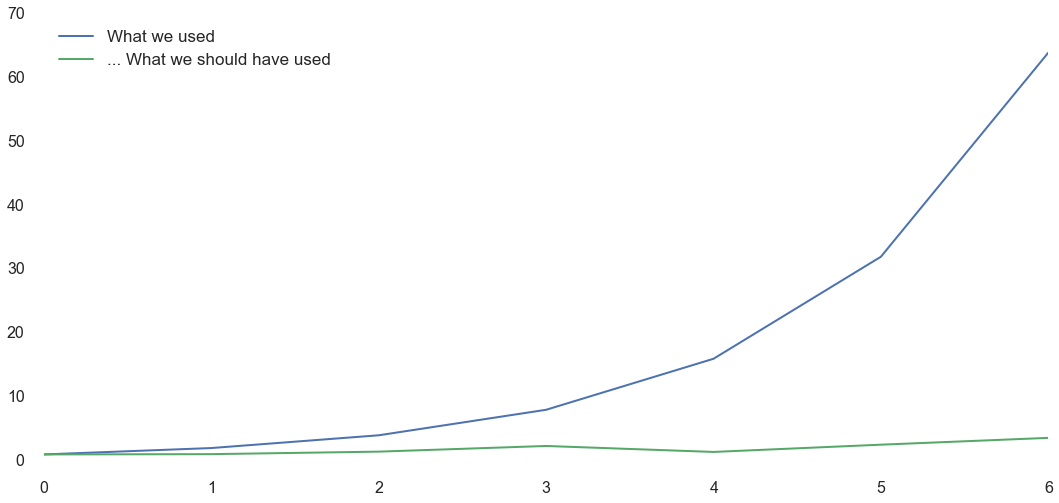

In [41]:
max_rank_score = votes.groupby('Rank').sum()['Points'].max()
rank_standardise = 1 / (votes.groupby('Rank').sum()['Points'] / max_rank_score)
std_adjustment = pd.DataFrame([[x * 8 for x in multiplier],rank_standardise.tolist()])
std_adjustment = std_adjustment.T.set_index(0)
std_adjustment.index.name = 'What we used'
std_adjustment.columns = ['... What we should have used']
with sns.plotting_context("poster", rc=c):
    std_adjustment.reset_index().plot()

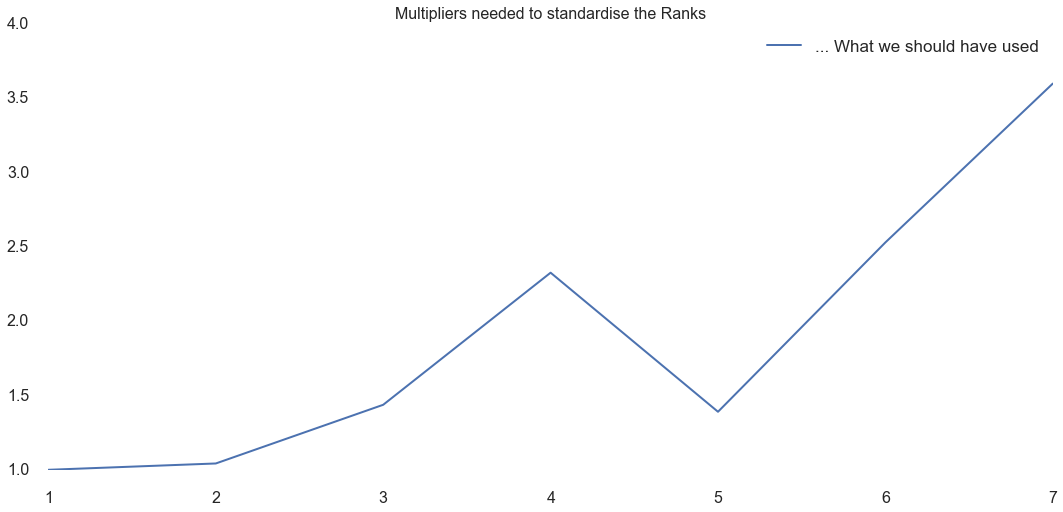

In [42]:
with sns.plotting_context("poster", rc=c):
    std_adjustment.index = range(1,8)
    std_adjustment.plot()
    plt.title('Multipliers needed to standardise the Ranks')

In [43]:
def ranked_table(df,rank_key='Points',ascending=False):
    df = df.sort(rank_key, ascending=ascending)
    df['Rank'] = rank(df[rank_key]).astype('int')
    pd.options.display.float_format = '{:.2f}'.format
    table(df)

In [44]:
award_title = 'Bleeding Heart'
h2_success(award_title)

In [45]:
from collections import defaultdict
bleeding_heart = defaultdict(int)

for idx, row in votes.iterrows():
    bleeding_heart[row.Player] += 1 / prestige.loc[row.Character]

bleeding_heart = pd.DataFrame(bleeding_heart.values(), index=bleeding_heart.keys(), columns=['Score'])
bleeding_heart['Adjusted'] = bleeding_heart.Score / player_voted_ratio.iloc[:,0]

winner = bleeding_heart.sort('Score',ascending=False).index[0]
desc = 'Who Disproportionately Voted for Non-prestigious Characters'
awarded_awards.append(award_desc(award_title, desc, winner))

h2_success(award_title)
h3_danger(winner)

ranked_table(bleeding_heart,'Adjusted')

,Score,Adjusted,Rank
Mart,605.33,6.09,1
Sherin the Sedulous,522.71,5.99,2
Rob o Bones,466.49,5.98,3
Kent,119.24,5.96,4
Hayley,493.98,5.57,5
Daisy,392.78,5.56,6
Dan,487.57,5.34,7
Josh Du,380.81,5.19,8
Kirsty,439.48,4.85,9
Max Ng,327.64,4.27,10


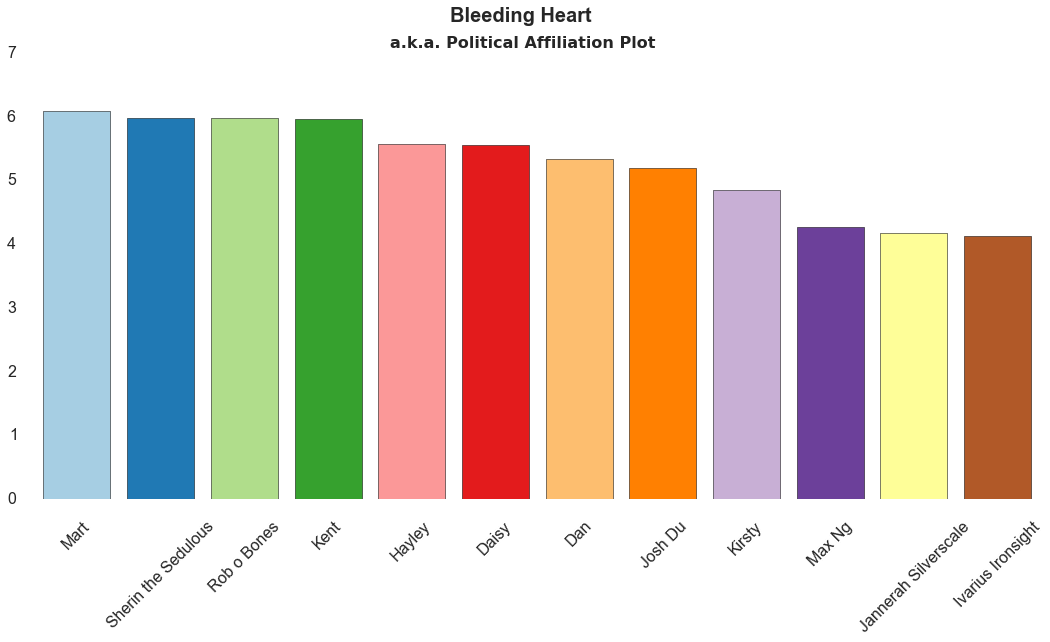

In [46]:
with sns.plotting_context("poster", rc=c):
    d = bleeding_heart.reset_index()
    d = d.sort('Adjusted', ascending=False)
    d.columns = ['Player'] + d.columns[1:].tolist()
    f, (ax) = plt.subplots(1, 1)

    g = sns.barplot("Player", 'Adjusted', data=d, x_order=d.Player, palette="Paired", ax=ax)
    
    ax.set_xticklabels(d.Player.tolist(), rotation=45)
    ax.set_title('a.k.a. Political Affiliation Plot', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle('Bleeding Heart', fontsize=20, fontweight='bold')
    
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [47]:
award_title = 'One Trick Pony'
desc = 'Who relied on a single character for the majority of their score'
h2_success(award_title)
h3(desc)


In [48]:
player_char_scores = {}

for player in votes.Player.unique().tolist():
    player_char_scores[player] = defaultdict(int)

for idx, row in scores_character.iterrows():
    
    for player in char_player_map[row.Character]:
        player_char_scores[player][row.Character] += roster[roster[player] == row.Character].index[0] * row.Points

player_score_breakdown = pd.DataFrame(columns=list(set(roster.values.ravel())), index=votes.Player.unique().tolist()).fillna(0)        
        
for player, characters in player_char_scores.iteritems():
    for character, points in characters.iteritems():
        player_score_breakdown.ix[player,character] = points
        
score_breakdown = player_score_breakdown.T.apply(lambda x : sorted_max(x, 7))
score_breakdown.iloc[0]
top_scoring_char_leverage = score_breakdown.iloc[0] / score_breakdown.sum(0)
top_scoring_char_leverage.order(ascending=False)
top_chars = player_score_breakdown.T.apply(argmax)
one_trick_pony = pd.concat([top_scoring_char_leverage,top_chars],axis=1)
one_trick_pony.columns = ['Share','Top Character']
one_trick_pony.Share = (one_trick_pony.Share * 100).astype(int)

winner = one_trick_pony.sort('Share').index[-1]

awarded_awards.append(award_desc(award_title, desc, winner))

h2_success(award_title)
h3_danger(winner)
ranked_table(one_trick_pony, 'Share')

,Share,Top Character,Rank
Daisy,71,Barristan Selmy,1
Rob o Bones,57,White Walkers Master,2
Ivarius Ironsight,53,Samwell Tarly,3
Kent,52,Tormund Giantsbane,4
Dan,50,Missandei,5
Jannerah Silverscale,49,Jorah Mormont,6
Kirsty,48,Shireen Baratheon,7
Mart,46,Qyburn,8
Josh Du,45,Tyene Sand,9
Sherin the Sedulous,39,Doran Martell,10


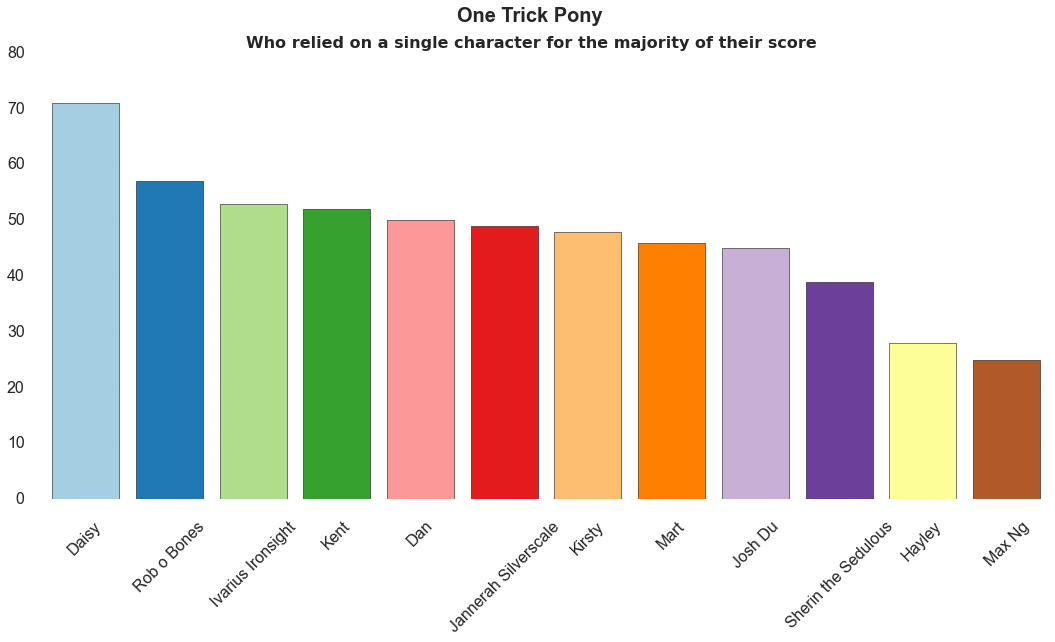

In [49]:
with sns.plotting_context("poster", rc=c):
    d = one_trick_pony.reset_index()
    d = d.sort('Share',ascending=False)
    d.columns = ['Player'] + d.columns[1:].tolist()
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot("Player", 'Share', data=d, x_order=d.Player, palette="Paired", ax=ax)
    ax.set_xticklabels(d.Player.tolist(), rotation=45)
    ax.set_title(desc, x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle(award_title, fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [50]:
award_title = 'War of Attrition'
desc = 'Who avoided giving away points by not voting for high-multiplier characters?'
h2_success(award_title)
h3(desc)


In [51]:
player_mult_given = defaultdict(int)

for idx, row in votes[['Character','Player']].iterrows():
    character = row.Character
    player = row.Player
    player_mult_given[player] += char_mult_map[character]

player_multiplier_avoidance = pd.DataFrame(player_mult_given.values(), index=player_mult_given.keys(), columns=['MultiSum'], dtype=int)
player_multiplier_avoidance['Adjusted_Multiplier'] = (player_multiplier_avoidance.MultiSum * (1 / player_voted_ratio['% Voted'] * 100 )).astype(int)
player_multiplier_avoidance = player_multiplier_avoidance.sort('Adjusted_Multiplier')
player_multiplier_avoidance['Rank'] = rank(-1*player_multiplier_avoidance.Adjusted_Multiplier).astype(int)

winner = player_multiplier_avoidance.index[0]

h2_success(award_title)
h3_danger(winner)

awarded_awards.append(award_desc(award_title, desc, winner))

table(player_multiplier_avoidance)

,MultiSum,Adjusted_Multiplier,Rank
Jannerah Silverscale,121,172,1
Ivarius Ironsight,147,193,2
Mart,193,194,3
Sherin the Sedulous,178,203,4
Dan,192,210,5
Max Ng,161,210,5
Kent,44,220,7
Kirsty,222,244,8
Rob o Bones,192,246,9
Hayley,220,248,10


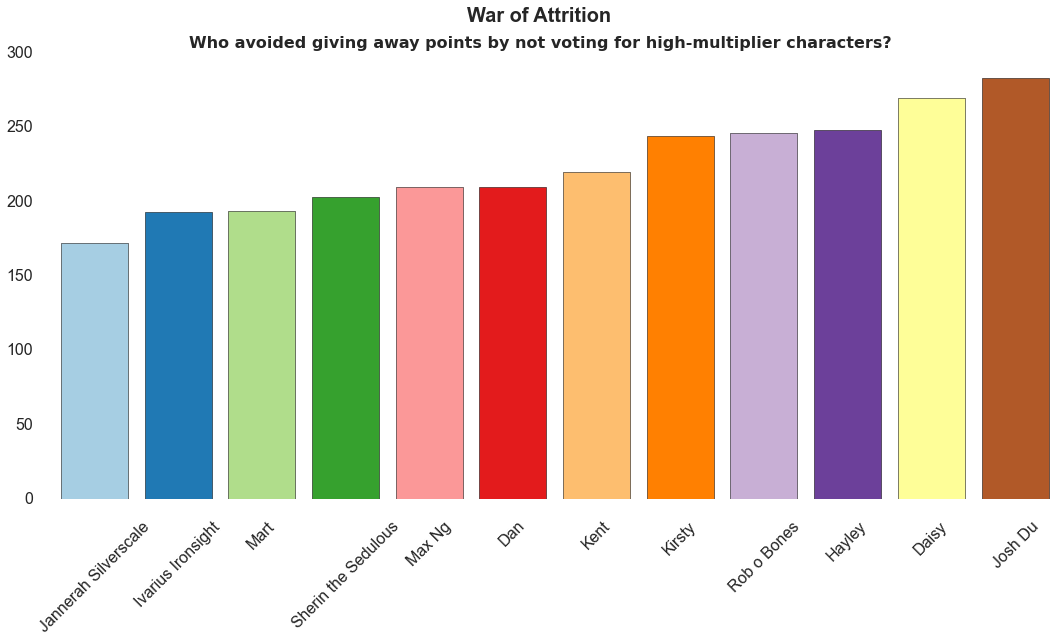

In [52]:
with sns.plotting_context("poster", rc=c):
    d = player_multiplier_avoidance.reset_index()
    d = d.sort('Adjusted_Multiplier',ascending=False)
    d.columns = ['Player'] + d.columns[1:].tolist()
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot("Player", 'Adjusted_Multiplier', data=d, x_order=d.Player[::-1], palette="Paired", ax=ax)
    ax.set_xticklabels(d.Player.tolist()[::-1], rotation=45)
    ax.set_title(desc, x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle(award_title, fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [53]:
award_title = 'Squeeze the Vote'
h2_success(award_title)

In [54]:
vote_efficiency = pd.DataFrame(score_table.Total / paired_votes.mean()).astype('int')
vote_efficiency.columns = ['Score']

desc = 'Most Efficient Use of Votes'
winner = vote_efficiency.sort('Score').index[-1]

awarded_awards.append(award_desc(award_title, desc, winner))

h2_success(award_title)
h3_danger(winner)

ranked_table(vote_efficiency, 'Score')

,Score,Rank
Kent,47315,1
Dan,38097,2
Ivarius Ironsight,35743,3
Sherin the Sedulous,31396,4
Daisy,28542,5
Jannerah Silverscale,24677,6
Hayley,21585,7
Mart,18600,8
Kirsty,17027,9
Max Ng,15371,10


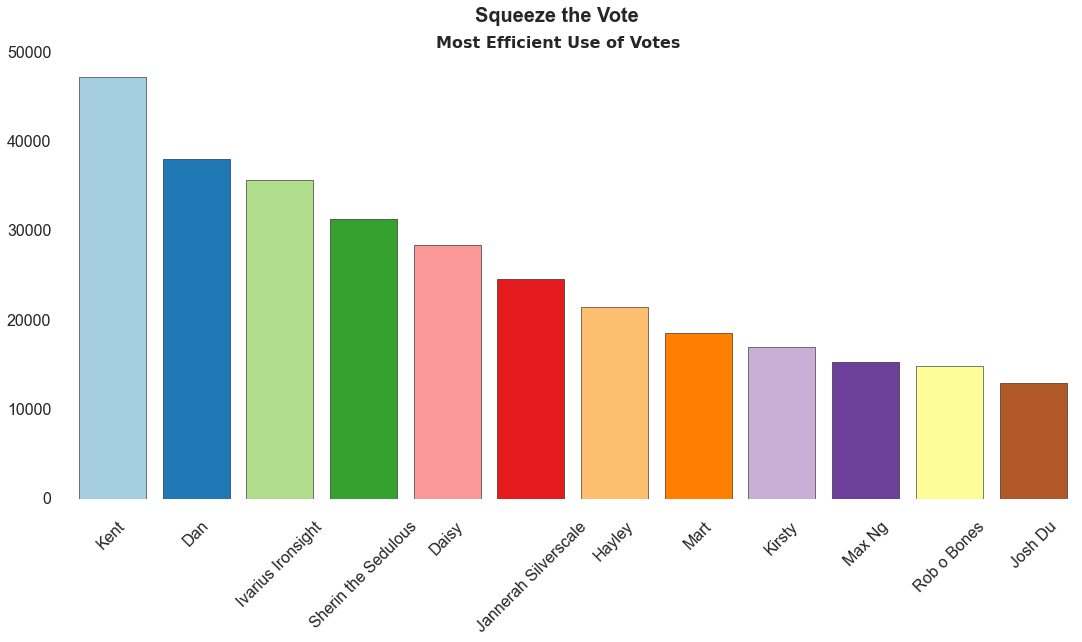

In [55]:
with sns.plotting_context("poster", rc=c):
    d = vote_efficiency.reset_index()
    d = d.sort('Score',ascending=False)
    d.columns = ['Player'] + d.columns[1:].tolist()
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot("Player", 'Score', data=d, x_order=d.Player, palette="Paired", ax=ax)
    ax.set_xticklabels(d.Player.tolist(), rotation=45)
    ax.set_title('Most Efficient Use of Votes', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle('Squeeze the Vote', fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

# Invisible Links

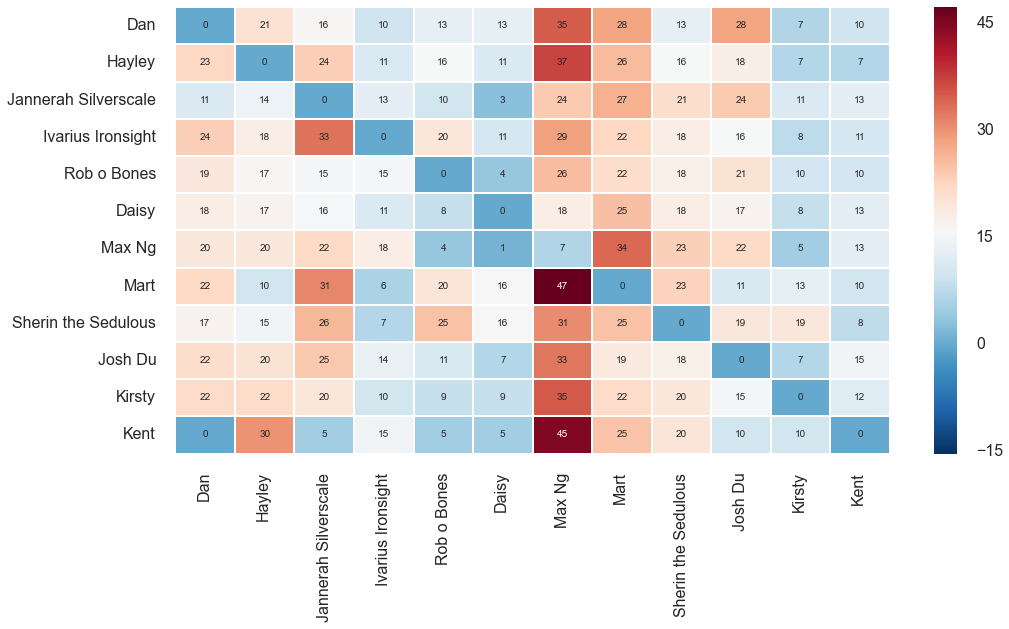

In [56]:
h2_success('General Pairwise Voting Patterns')
h3('X = Recipient, Y = Voter') 
        
with sns.plotting_context("poster", rc=thin_c):
    sns.heatmap(paired_votes*100, annot=True, fmt='.0f', center=16, annot_kws=None);

In [57]:
# invisible_links = pd.DataFrame(bleeding_heart.values(), index=bleeding_heart.keys(), columns=['Score'])

# invisible_links['Adjusted'] = bleeding_heart.Score / player_voted_ratio.iloc[:,0]
# invisible_links = bleeding_heart.sort('Adjusted',ascending=False)
# bleeding_heart['Rank'] = rank(bleeding_heart.Adjusted).astype('int')
# table(bleeding_heart)

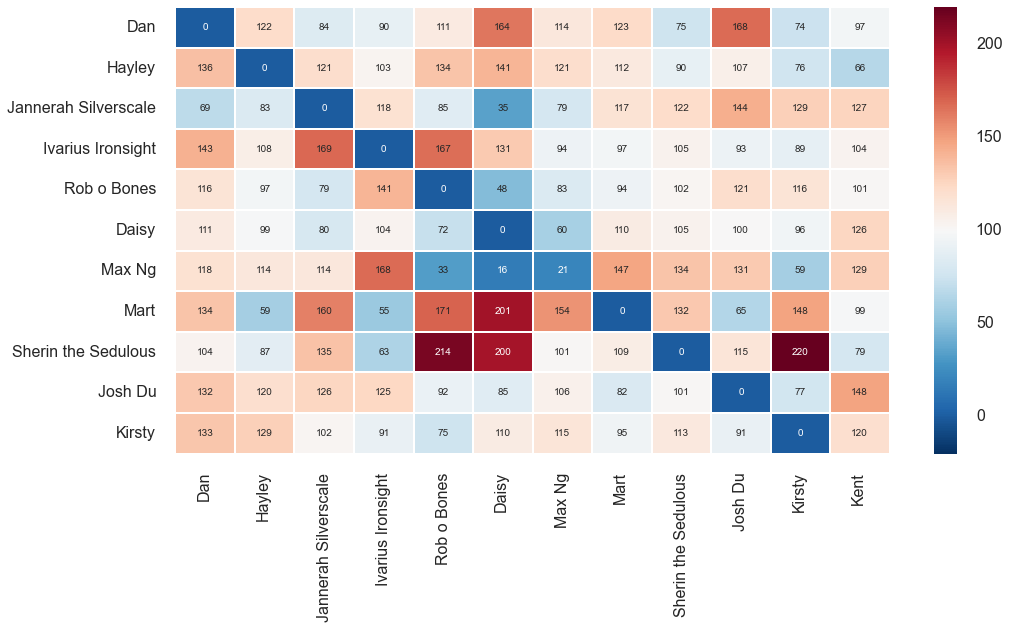

In [58]:
h2_success('Pairwise Voting Patterns, Standardised by Recipient Strength')
h3('X = Recipient, Y = Voter') 

invisible_links_paired = (paired_votes / paired_votes.mean() * 100).astype(int)

with sns.plotting_context("poster", rc=thin_c):
    sns.heatmap(invisible_links_paired.ix[:-1,:], annot=True, fmt='d', center=100, annot_kws=None);

In [59]:
h2('Invisible Links')
h3('Top 10 Most Suspicious Favouritism')
invisible_links_paired_long = pd.melt(invisible_links_paired.ix[:-1,:].reset_index(), id_vars=['index'])
invisible_links_paired_long.columns = ['Voter','Recipient','Index']
table(invisible_links_paired_long.sort('Index',ascending=False)[:10], index=False)

Voter,Recipient,Index
Sherin the Sedulous,Kirsty,220
Sherin the Sedulous,Rob o Bones,214
Mart,Daisy,201
Sherin the Sedulous,Daisy,200
Mart,Rob o Bones,171
Ivarius Ironsight,Jannerah Silverscale,169
Dan,Josh Du,168
Max Ng,Ivarius Ironsight,168
Ivarius Ironsight,Rob o Bones,167
Dan,Daisy,164


In [60]:
h2('Invisible Links')
h3('Top 10 Most Suspicious Neglect')
table(invisible_links_paired_long[invisible_links_paired_long.Index > 0].sort('Index',ascending=True)[:10], index=False)

Voter,Recipient,Index
Max Ng,Daisy,16
Max Ng,Max Ng,21
Max Ng,Rob o Bones,33
Jannerah Silverscale,Daisy,35
Rob o Bones,Daisy,48
Mart,Ivarius Ironsight,55
Mart,Hayley,59
Max Ng,Kirsty,59
Daisy,Max Ng,60
Sherin the Sedulous,Ivarius Ironsight,63


In [61]:
award_title = 'Most Controversial Rosters'
desc = 'Standard Deviation of votes received'
h2_success(award_title)
h3(desc) 

In [62]:
std_play = pd.DataFrame(invisible_links_paired.std(0).order(ascending=False))
std_play.columns = ['Score']
winner = std_play.index[0]

awarded_awards.append(award_desc(award_title,desc,winner))

h2_success(award_title)
h3_danger(winner)
ranked_table(std_play,'Score')

,Score,Rank
Daisy,69.21,1
Rob o Bones,62.78,2
Kirsty,53.57,3
Dan,50.53,4
Jannerah Silverscale,50.11,5
Ivarius Ironsight,45.02,6
Josh Du,43.97,7
Hayley,42.54,8
Kent,38.82,9
Max Ng,36.47,10


In [63]:
award_title = 'Odd-Ball'
desc = 'Standard Deviation of votes given'
h2_success(award_title)
h3(desc) 

In [64]:
std_play = pd.DataFrame(invisible_links_paired.std(1).order(ascending=False))
std_play.columns = ['Score']

winner = std_play.index[0]
awarded_awards.append(award_desc(award_title,desc,winner))

h2_success(award_title)
h3_danger(winner)

ranked_table(std_play,'Score')

,Score,Rank
Sherin the Sedulous,65.11,1
Mart,59.19,2
Kent,58.84,3
Max Ng,52.18,4
Dan,44.39,5
Ivarius Ironsight,44.26,6
Jannerah Silverscale,42.68,7
Hayley,39.36,8
Josh Du,38.38,9
Rob o Bones,37.24,10


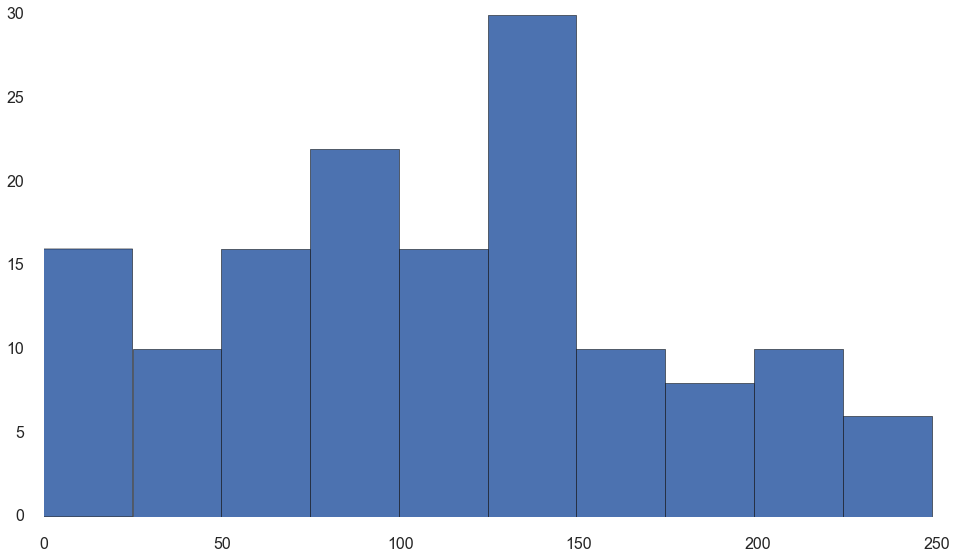

In [65]:
reciprocal_links = (invisible_links_paired * invisible_links_paired.T) / 100

h2_success('Collective Voting Mentality')
h3('Histograms of how our votes were to each other - how polarising is this show?') 
with sns.plotting_context("poster", rc=dict(c,**{'figure.figsize':[16,9]})):                     
    pd.Series(reciprocal_links.values.ravel()).hist()


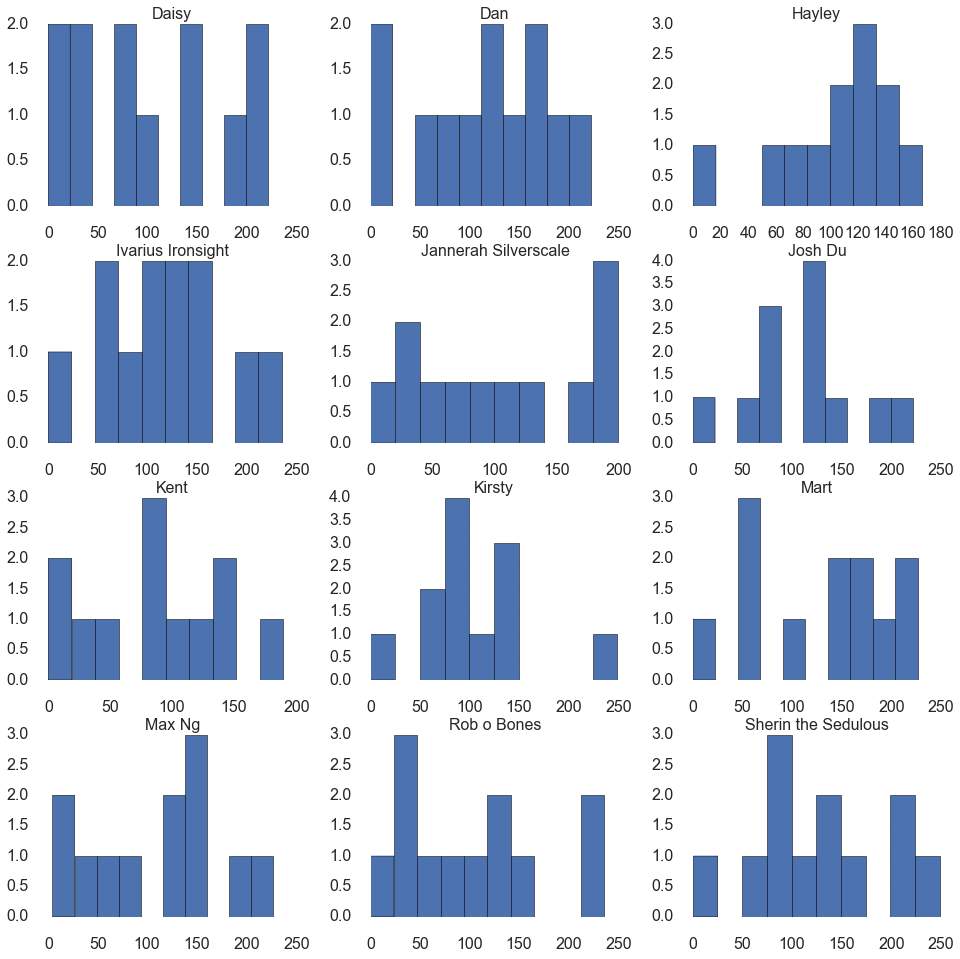

In [66]:
h2_success('Individual Voting Mentality')
h3('Histograms of how similar you voted with to players') 
with sns.plotting_context("poster", rc=dict(c,**{'figure.figsize':[16,16]})):                     
    reciprocal_links.hist()

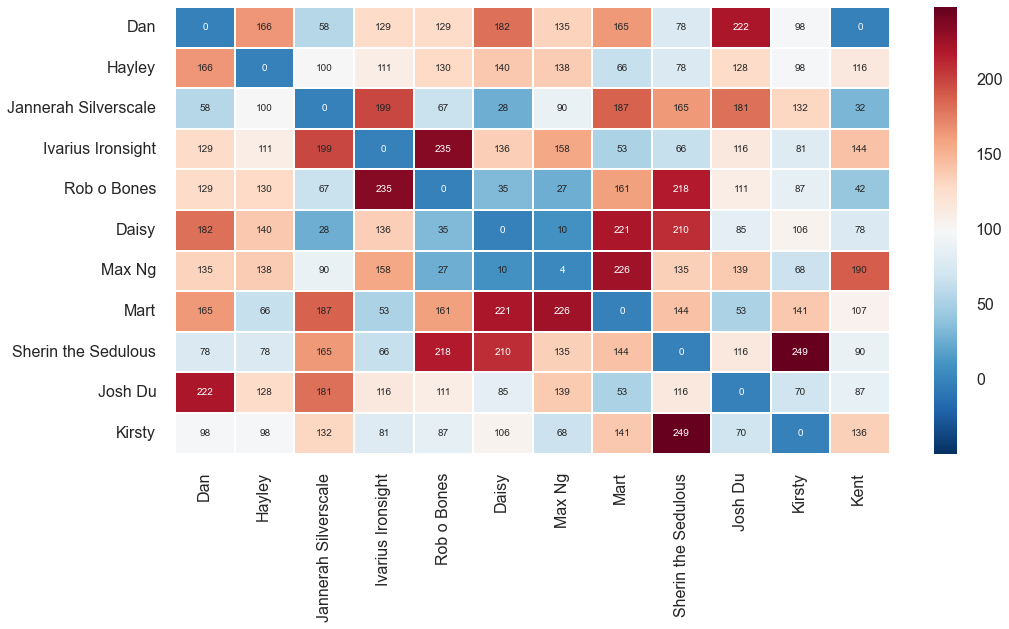

In [67]:
h2_success('Reciprocity')
h3('You Scratch My Back, I Scratch Yours?')


with sns.plotting_context("poster", rc=thin_c):
    sns.heatmap(reciprocal_links.ix[:-1,:], annot=True, fmt='.0f', center=100, annot_kws=None);

In [68]:
h2('Invisible Links')
h3('Top 5 Most Dubious Exchanges')
reciprocal_links_long = pd.melt(reciprocal_links.astype('int').reset_index(), id_vars=['index'])
reciprocal_links_long.columns = ['Suspect A','Suspect B','Index']
table(reciprocal_links_long.sort('Index',ascending=False).iloc[::2,][:5], index=False)

Suspect A,Suspect B,Index
Sherin the Sedulous,Kirsty,248
Ivarius Ironsight,Rob o Bones,235
Mart,Max Ng,226
Dan,Josh Du,221
Daisy,Mart,221


In [69]:
h2('Invisible Links')
h3('Top 5 Animosity')
reciprocal_links_long = pd.melt(reciprocal_links.astype('int').reset_index(), id_vars=['index'])
reciprocal_links_long.columns = ['Suspect A','Suspect B','Index']
table(reciprocal_links_long[reciprocal_links_long.Index>3].sort('Index',ascending=True).iloc[::2,][:5], index=False)

Suspect A,Suspect B,Index
Max Ng,Max Ng,4
Daisy,Max Ng,9
Max Ng,Rob o Bones,27
Daisy,Jannerah Silverscale,28
Jannerah Silverscale,Kent,31


# Game Awards

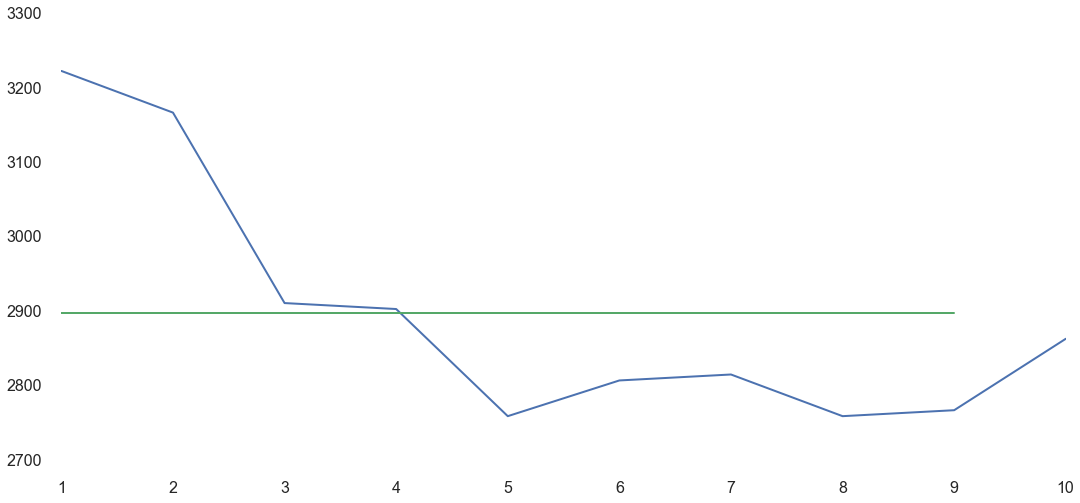

In [70]:
h2_success('Number of Points Available per Episode')
h3('The Kent Effect')
with sns.plotting_context("poster", rc=c):
    t = votes.groupby('Episode').Points.sum()
    t.index = range(1,len(t.index)+1)
    t.plot()
    plt.plot(range(10),[t.mean()]*10)
    plt.ylim = (100,170)

In [71]:
h2_success('Player Participation Rates')

table(player_voted_ratio.astype('int'))

,% Voted,Rank,Disqualified
Mart,99,1,0
Dan,91,2,0
Kirsty,90,3,0
Hayley,88,4,0
Sherin the Sedulous,87,5,0
Rob o Bones,77,6,0
Max Ng,76,7,0
Ivarius Ironsight,76,8,0
Josh Du,73,9,0
Daisy,70,10,0


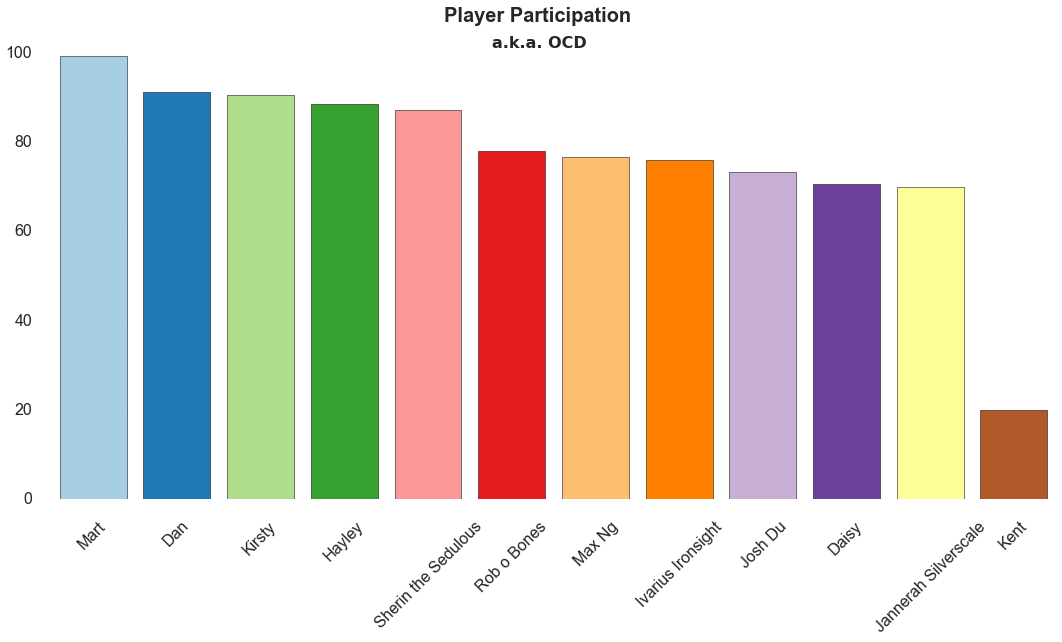

In [72]:
with sns.plotting_context("poster", rc=c):
    d = player_voted_ratio.reset_index()
    d.columns = ['Player','Ratio','Rank','Disqualified']
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot("Player", 'Ratio', data=d, x_order=d.Player, palette="Paired", ax=ax)
    ax.set_xticklabels(d.Player, rotation=45)
    ax.set_title('a.k.a. OCD', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle('Player Participation', fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [73]:
award_title = 'Quickfinger Award'
desc = 'Fastest Airtime-to-Vote Speed'
h2_success(award_title)
h3(desc)

In [74]:
first_ep_airdate = pd.datetime(2015,4,13,9,0)
airdates = []

for ep in range(10):
    airdates.append(first_ep_airdate + pd.tseries.offsets.DateOffset(days=7*ep))

def calc_vote_delay(g):
    ep_count = 9
    #     finale_viewing = (np.array(airdates[ep_count-1]) + pd.tseries.offsets.DateOffset(days=4))
    # if g.Player in ['Mart','Rob o\' Bones','Sherin the Sedulous','Daisy']:
    return (g.Timestamp[:ep_count] - np.array(airdates[:ep_count])).astype('timedelta64[h]')
    
vote_delays = vote_timestamps[vote_timestamps.Player != 'Kent'].groupby('Player').apply(calc_vote_delay)
vote_delays = vote_delays.reset_index()[['Player','Timestamp']]
vote_delays_ranked = vote_delays.groupby('Player').sum()
vote_delays_ranked = vote_delays_ranked.sort('Timestamp')

vote_delays_finale = vote_delays_ranked.reset_index()
finale_voters = vote_delays_finale.Player.isin(['Mart','Rob o\' Bones','Sherin the Sedulous','Daisy'])
vote_delays_finale.ix[finale_voters, 'Timestamp'] -= 4*24

# Adjust for Finale Delayed Viewing
vote_delays_finale.columns = ['Player','Hours Delay']
vote_delays_finale['Rank'] = rank(vote_delays_finale['Hours Delay'])[::-1]
vote_delays_finale = vote_delays_finale.sort('Rank')
vote_delays_finale = vote_delays_finale.set_index('Player')

winner = vote_delays_finale.index[0]
h2_success(award_title)
h3_danger(winner)

awarded_awards.append(award_desc(award_title,desc,winner))

table(vote_delays_finale.astype(int))

,Hours Delay,Rank
Player,,
Mart,89,1
Sherin the Sedulous,144,2
Kirsty,240,3
Hayley,280,4
Dan,281,5
Jannerah Silverscale,290,6
Ivarius Ironsight,362,7
Max Ng,677,8
Daisy,687,9


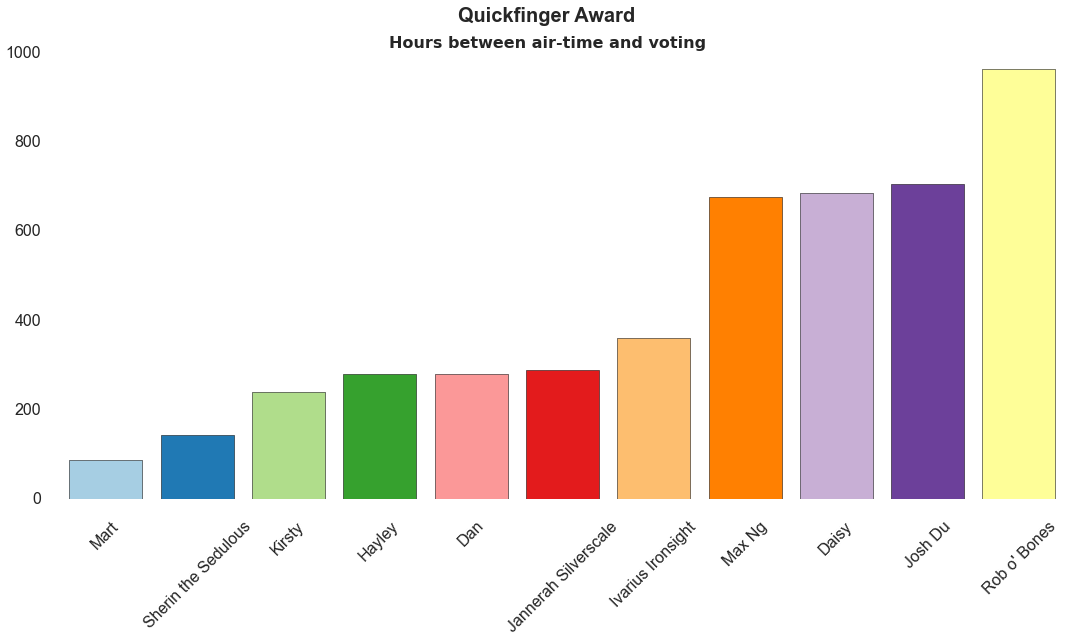

In [75]:
with sns.plotting_context("poster", rc=c):
    d = vote_delays_finale.sort('Hours Delay').reset_index()
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot('Player', 'Hours Delay', data=d, x_order=d.Player, palette="Paired", ax=ax)
    ax.set_xticklabels(d.Player, rotation=45)
    ax.set_title('Hours between air-time and voting', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle(award_title, fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [76]:
current_score_table = scores_player.groupby(level=0).sum().T
index = current_score_table.index
columns = range(len(current_score_table.columns),11)
df_ = pd.DataFrame(index=index, columns=columns)
df_ = df_.fillna(0) # with 0s rather than NaNs
score_table =  pd.concat([current_score_table, df_], axis=1)
score_table.columns = range(1,11) + ['Total']
score_table.Total = score_table.T.sum()

In [77]:
award_title = 'Sleeper Hit'
desc = 'Roster Most Outperforming Expectations'
h2_success(award_title)
h3(desc)

In [78]:
score_std_by_roster_prestige = score_table.Total / roster_prestige.Score
score_std_by_roster_prestige = pd.DataFrame(score_std_by_roster_prestige.tolist(), index=score_std_by_roster_prestige.index)
score_std_by_roster_prestige.columns = ['Points']

winner = score_std_by_roster_prestige.sort('Points').index[-1]

h2_success(award_title)
h3_danger(winner)

awarded_awards.append(award_desc(award_title, desc, winner))

ranked_table(score_std_by_roster_prestige,'Points')

,Points,Rank
Dan,344.55,1
Ivarius Ironsight,231.94,2
Sherin the Sedulous,177.39,3
Kent,165.58,4
Mart,164.81,5
Hayley,162.34,6
Max Ng,120.64,7
Kirsty,115.69,8
Jannerah Silverscale,113.78,9
Josh Du,102.97,10


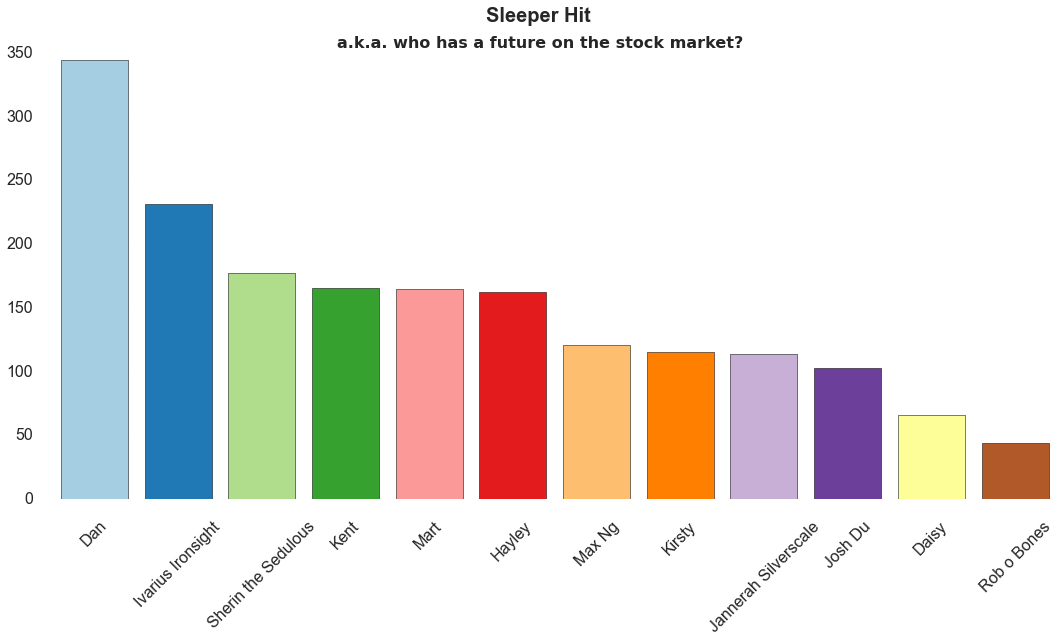

In [79]:
with sns.plotting_context("poster", rc=c):
    d = score_std_by_roster_prestige.reset_index()
    d = d.sort('Points',ascending=False)
    d.columns = ['Player'] + d.columns[1:].tolist()
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot("Player", 'Points', data=d, x_order=d.Player, palette="Paired", ax=ax)
    ax.set_xticklabels(d.Player.tolist(), rotation=45)
    ax.set_title('a.k.a. who has a future on the stock market?', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle(award_title, fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [80]:
award_title = 'Shadow Game'
desc = 'Points Awarded Standardised by Rank'
h2_success(award_title)
h3(desc)

In [81]:
votes['Points_Standardised'] = rank_standardise[votes.Rank].tolist() * votes.Points

# votes.groupby(['Episode','Player'])['Points_Standardised'].sum().reset_index().pivot('Player','Episode')

std_scores = pd.DataFrame(index=votes.Player.unique().tolist(), columns=range(1,11)).fillna(0)

for idx, row in votes[['Points_Standardised','Character','Episode']].iterrows():
    char = row.Character
    points = row.Points_Standardised
    ep = row.Episode
    for mult, row in roster.iterrows():
        for idx, roster_char in enumerate(row):
            if char == roster_char:
                player = str(row.index[idx])
                std_scores.ix[player,ep+1] += points

pd.options.display.float_format = '{:.2f}'.format

std_scores['Total'] = std_scores.sum(1)
std_scores = std_scores.sort('Total', ascending=False)
std_scores['Rank'] = rank(std_scores.Total)
std_scores = std_scores[[u'Rank', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, u'Total']]

winner = std_scores.index[0]
awarded_awards.append(award_desc(award_title,desc,winner))

h2_success(award_title)
h3_danger(winner)

table(std_scores[['Rank','Total']].astype('int'))

,Rank,Total
Max Ng,1,8730
Mart,2,5601
Dan,3,5431
Hayley,4,5424
Jannerah Silverscale,5,5397
Sherin the Sedulous,6,5184
Josh Du,7,4253
Kent,8,3924
Ivarius Ironsight,9,3064
Rob o Bones,10,2956


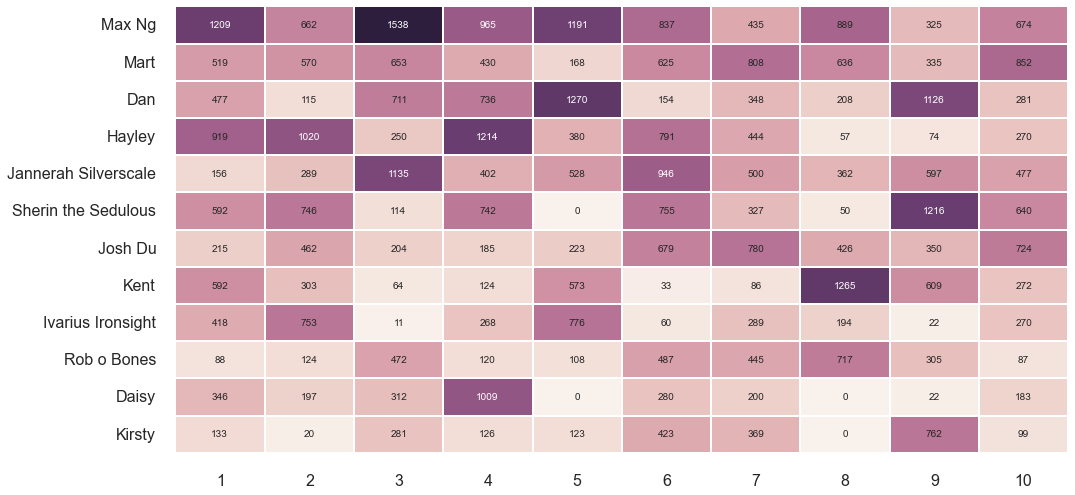

In [82]:
h2(award_title)
h3('Heatmap of points won under Shadow Game Rules')
with sns.plotting_context("poster", rc=thin_c):
    sns.heatmap(std_scores.ix[:,1:-1].astype(int64), annot=True, fmt='d', yticklabels=True, annot_kws=None, cbar=False);

In [83]:
award_title = 'Lifting the Veil'
desc = 'Points Awarded without Multipliers'
h2_success(award_title)
h3(desc)

In [84]:
denorm_scores = pd.DataFrame(index=votes.Player.unique().tolist(), columns=range(1,11)).fillna(0)

for idx, row in votes[['Points','Character','Episode']].iterrows():
    char = row.Character
    points = row.Points
    ep = row.Episode
    for mult, row in roster.iterrows():
        for idx, roster_char in enumerate(row):
            if char == roster_char:
                player = str(row.index[idx])
                denorm_scores.ix[player,ep+1] += points

pd.options.display.float_format = '{:.2f}'.format

denorm_scores['Total'] = denorm_scores.sum(1)
denorm_scores = denorm_scores.sort('Total', ascending=False)
denorm_scores['Rank'] = rank(denorm_scores.Total)
denorm_scores = denorm_scores[[u'Rank', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, u'Total']]

winner = denorm_scores.index[0]
awarded_awards.append(award_desc(award_title,desc,winner))

h2_success(award_title)
h3_danger(winner)

table(std_scores[['Rank','Total']].astype('int'))

,Rank,Total
Max Ng,1,8730
Mart,2,5601
Dan,3,5431
Hayley,4,5424
Jannerah Silverscale,5,5397
Sherin the Sedulous,6,5184
Josh Du,7,4253
Kent,8,3924
Ivarius Ironsight,9,3064
Rob o Bones,10,2956


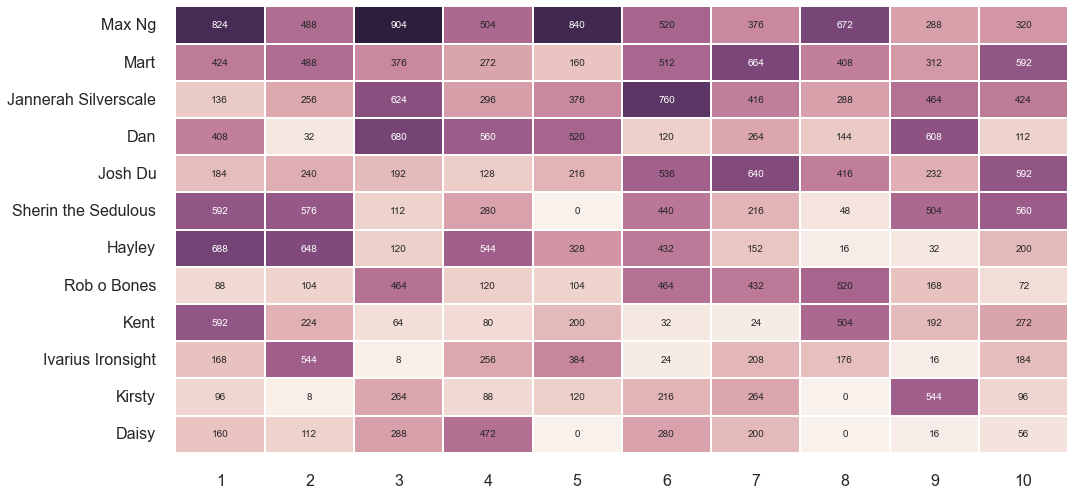

In [85]:
h2(award_title)
h3('Heatmap of points won in a Game without Multipliers')
with sns.plotting_context("poster", rc=thin_c):
    sns.heatmap(denorm_scores.ix[:,1:-1].astype(int64), annot=True, fmt='d', yticklabels=True, annot_kws=None, cbar=False);

# ASCENSION AWARD

In [86]:
score_table = score_table.sort('Total',ascending=False)

award_title = 'Ascension Award'
desc = 'Most points. No bullshit.'
winner = score_table.index[0]
awarded_awards.append(award_desc(award_title,desc,winner))

h2_success(award_title)
h3(desc)

In [87]:
h2_success(award_title)
h3_danger(winner)
ranked_table(score_table.astype(int),'Total')

,1,2,3,4,5,6,7,8,9,10,Total,Rank
Dan,111,256,235,382,2504,180,438,242,1464,476,6288,1
Sherin the Sedulous,74,623,20,1520,0,780,168,12,1872,408,5477,2
Jannerah Silverscale,35,73,1638,379,572,493,457,328,690,128,4793,3
Kent,74,187,8,144,1056,8,192,1988,1088,36,4781,4
Max Ng,681,221,1438,433,880,275,121,204,132,320,4705,5
Mart,274,399,782,519,30,293,218,744,144,882,4285,6
Ivarius Ironsight,630,1073,16,92,1156,96,416,100,32,274,3885,7
Hayley,723,782,312,516,86,312,705,128,32,77,3673,8
Daisy,29,231,102,1423,0,35,25,0,32,400,2277,9
Josh Du,44,177,56,119,42,221,724,68,258,492,2201,10


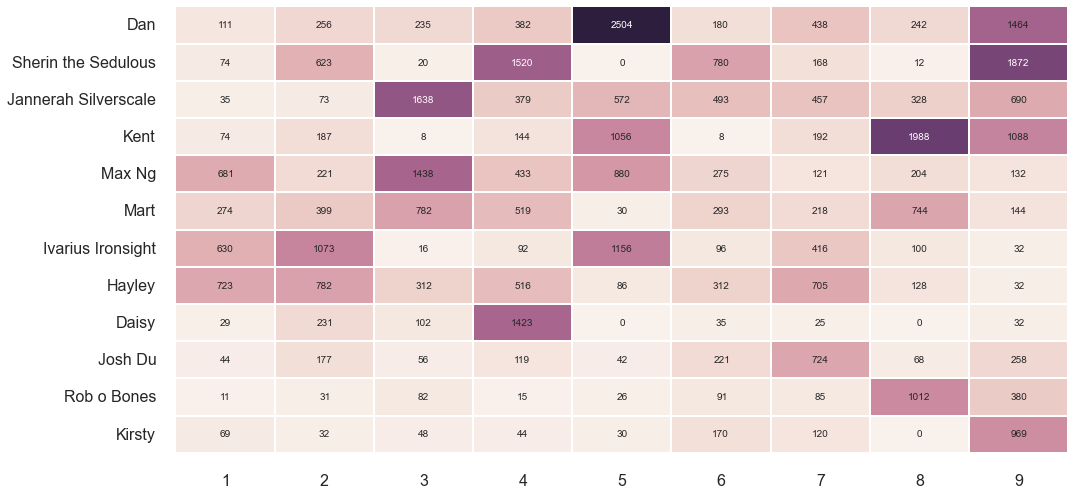

In [88]:
h3_info('Roster Breakdown')
# Searborn Heatmap of cummulative points earned per player, adjusted for rank
with sns.plotting_context("poster", rc=thin_c):
    sns.heatmap(score_table.ix[:,:-2].astype(int64), annot=True, fmt='d', yticklabels=True, annot_kws=None, cbar=False);

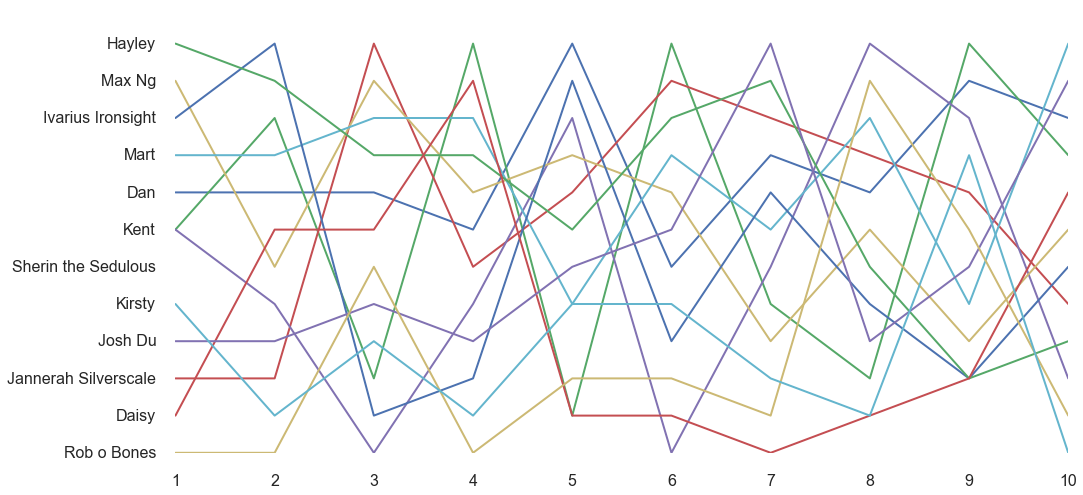

In [89]:
h2_success('POWER METER')
h3_info('Ranking')
p('Line chart tracing the player ranks over season')
power_meter = score_table.copy()
for ep in score_table:
    power_meter[ep] = rank(score_table[ep])
with sns.plotting_context("poster", font_scale=1, rc=thin_c):
    plt.plot(power_meter.ix[:,:len(episode_list)].T)
    plt.gca().invert_yaxis()
#     plt.ylim([13,1])
    plt.yticks(arange(1,13), score_table[1].order(ascending=False).index )
    plt.xticks(arange(0,len(episode_list)),power_meter.columns)

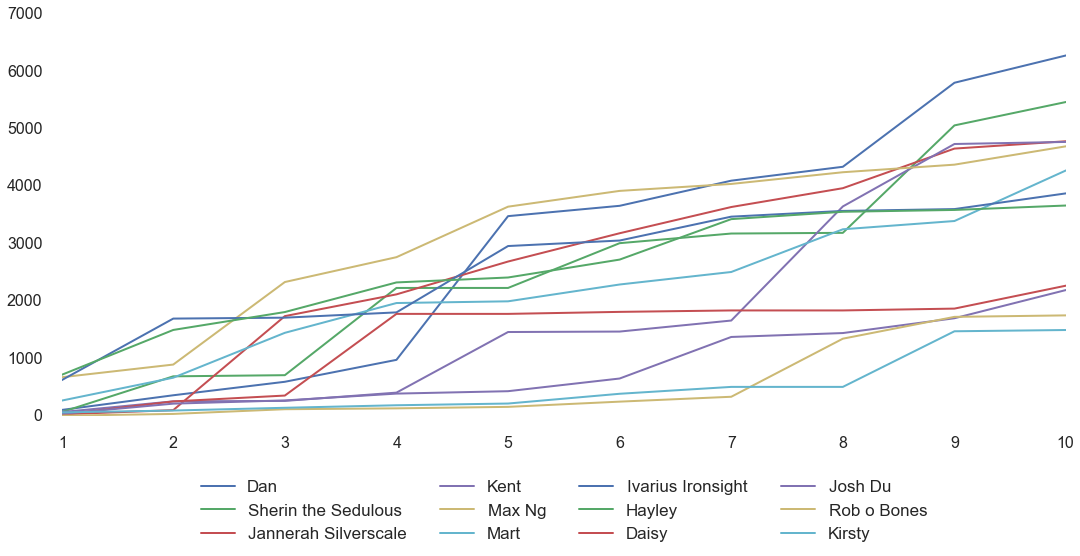

In [90]:
h3_info('THE GREAT ASCENT')
p('Line chart tracing the player total points over season')

score_meter = score_table.T
for player in score_meter:
    score_meter.ix[:10, player] = score_meter.ix[:10, player].cumsum()
    
    
with sns.plotting_context("poster", font_scale=1, rc=c):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    for i in xrange(1,13):
        ax.plot(score_meter.index[:len(episode_list)], score_meter.ix[:len(episode_list),i-1], label=score_meter.columns[i-1])

    plt.xticks(arange(1,len(episode_list) + 1), power_meter.columns)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
              fancybox=False, ncol=4)

In [91]:
h2_success('AWARD REAPINGS')
award_reapings = pd.DataFrame(awarded_awards)
award_reapings.columns = ['Description','Award','Winner']
award_reapings = award_reapings[['Award','Winner','Description']]
h3_info('Character Award')
table(award_reapings[-award_reapings.Winner.isin(votes.Player.unique().tolist())],index=False)


Award,Winner,Description
Wit,Tyrion Lannister,Character who accumalted most points in the Wi...
Jockey,Cersei Lannister,Character who accumalted most points in the Jo...
Bloodshed,Ramsay Bolton,Character who accumalted most points in the Bl...
Style,Daenerys Targaryen,Character who accumalted most points in the St...
Support,Samwell Tarly,Character who accumalted most points in the Su...
Most Valuable Player,Tyrion Lannister,Player who accumulated the most points across ...


In [92]:
h3_info('Player Awards')
table(award_reapings[award_reapings.Winner.isin(votes.Player.unique().tolist())], index=False)

Award,Winner,Description
Player Wit,Mart,Player who accumalted most points in the Wit ...
Player Jockey,Max Ng,Player who accumalted most points in the Jocke...
Player Bloodshed,Max Ng,Player who accumalted most points in the Blood...
Player Style,Max Ng,Player who accumalted most points in the Style...
Player Support,Hayley,Player who accumalted most points in the Suppo...
Bleeding Heart,Mart,Who Disproportionately Voted for Non-prestigio...
One Trick Pony,Daisy,Who relied on a single character for the major...
War of Attrition,Jannerah Silverscale,Who avoided giving away points by not voting f...
Squeeze the Vote,Kent,Most Efficient Use of Votes
Most Controversial Rosters,Daisy,Standard Deviation of votes received


In [93]:
h1('Thanks for Playing!')

In [94]:
HTML('''<a class='btn btn-warning btn-lg' style="margin:0 auto; display:block; max-width:320px" href="javascript:code_toggle()">TOGGLE CODE</a>''')

In [95]:
HTML('''<link href='http://fonts.googleapis.com/css?family=Roboto|Open+Sans' rel='stylesheet' type='text/css'>
<script>$(function(){$('.table *').css('text-align','center');
$('body').css('font-family', "'Open Sans','Source Sans Pro','Proxima Nova', sans-serif");$('h1,h2,h3,h4,h5').css('font-family', "'Roboto','Source Sans Pro','Proxima Nova', sans-serif");
$('.table, .table *').css('border',0)})</script>''')

In [96]:
HTML('''
<link href='http://fonts.googleapis.com/css?family=Roboto|Open+Sans' rel='stylesheet' type='text/css'>
<style>
body #notebook {
    font-family : 'Open Sans','Source Sans Pro','Proxima Nova', sans-serif;
    line-height: 1.4em;
    font-size: 1.2em;
    padding: 0 32px;
    line-height: 1.8em;
}

#notebook h1,
#notebook h2,
#notebook h3,
#notebook h4,
#notebook h5 {
    font-family : 'Roboto','Source Sans Pro','Proxima Nova', sans-serif;
}


#notebook .panel-body {
  font-size: 1.1em;
  line-height: 1.6em;
}

#notebook .table,
#notebook .table th,
#notebook .table td,
#notebook .table tr {
    text-align : center;
    border: 0;
    font-size: 1.5rem;
    line-height: 2.2rem
}


.badge {
  padding: 6px 14px 6px;
  font-size: 16px;
  font-weight: bold;
  white-space: nowrap;
  color: #ffffff;
  background-color: #999999;
  -webkit-border-radius: 12px;
  -moz-border-radius: 12px;
  border-radius: 16px;
  margin: 4px;
  line-height: 1.4em;
}
.badge:hover {
  color: #ffffff;
  text-decoration: none;
  cursor: pointer;
}
.badge-error {
  background-color: #b94a48;
}
.badge-error:hover {
  background-color: #953b39;
}
.badge-warning {
  background-color: #f89406;
}
.badge-warning:hover {
  background-color: #c67605;
}
.badge-success {
  background-color: #468847;
}
.badge-success:hover {
  background-color: #356635;
}
.badge-info {
  background-color: #3a87ad;
}
.badge-info:hover {
  background-color: #2d6987;
}
.badge-inverse {
  background-color: #333333;
}
.badge-inverse:hover {
  background-color: #1a1a1a;
}
</style>

<script>
$(function(){
    code_toggle()
    $('#notebook-container > b').contents().unwrap();
})
</script>
''')